<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-dsercam/blob/main/RetoFinal/RetoFinal_Entrega2_A01182676.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color="darkblue">Reto: Actividad Final</font>**
##**<font color="darkorange">  Entrega 2</font>**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Ciencia y analítica de datos**
####**Tecnológico de Monterrey**
#####**Prof: María de la Paz Rico Fernández**

###**<font color="darkgray">Nombre del estudiante: Dante Rodrigo Serna Camarillo</font>**
###**<font color="darkgray">Matrícula: A01182676</font>**

####**<font color="darkpurple"> URL Github: https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/blob/main/RetoFinal/RetoFinal_Entrega2_A01182676.ipynb</font>**


## <font color="darkorange"><b> Imports and installs

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 662 kB/s 
     |████████████████████████████████| 1.0 MB 12.4 MB/s 
     |████████████████████████████████| 1.7 MB 6.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 51.3 MB/s 
     |████████████████████████████████| 6.3 MB 39.1 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=eca4f7a50752c234b137ca29761fa71eba20ba1a9e8e21250c185653eb21b2f6
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=efeb94a946b9cc9f80922707e0ac7d563f511b97a8939ca50ebd761a386c2f7c
  Stored in directory: /root/.c

In [2]:
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from shapely.geometry import Point # para definir cooredans que puedan ser usadas con geopy
import geopandas as gpd #para graficar en mapa
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## <font color="darkorange"><b> Carga de shape files para mexico

Obtenemos los shape files de Mexico, disponibles en un zip dentro del repo. Realizamos un unzip para cargar los datos en nuestro enterno de google colab.

In [4]:
!wget https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
!unzip /content/mapa_mexico.zip

--2022-11-18 01:18:40--  https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip [following]
--2022-11-18 01:18:40--  https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11342120 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip’

mapa_mexico.zip     100%[===================>]  10.82M

Leer el shape file con geopandas.

In [5]:
mx = gpd.read_file('mapa_mexico/').set_index('CLAVE')
        #.to_crs(epsg=4485)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
CLAVE,,,,,,
02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-117.09481 32.41141, -117.09481 32.4..."
02003,Tecate,Baja California,02,003,3670.991923,"POLYGON ((-116.73791 32.56703, -116.65926 32.5..."
02002,Mexicali,Baja California,02,002,13119.275713,"POLYGON ((-115.81505 32.64088, -115.70466 32.6..."
02005,Playas de Rosarito,Baja California,02,005,517.120801,"POLYGON ((-117.06254 32.34436, -117.06276 32.3..."
26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((-114.96166 32.36465, -114.96239 32.3..."


## <font color="darkorange"><b> Fetch de data sets

In [6]:
#Permalinks a nuestros CSVs
#csvAguasSubterraneas  = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
csvAguasSuperficiales = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"


In [7]:
#Config para ver todas las columnas de los dataframes
pd.set_option('display.max_columns', None)

In [8]:
#Fetch de datos
#dfUnprocessedSubterraneas  = pd.read_csv(csvAguasSubterraneas, skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')
dfUnprocessedSuperficiales = pd.read_csv(csvAguasSuperficiales,  skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')


In [9]:
print('--------'*10)
print("Dimensiones DataFrame aguas superficiales (sin procesar): ", dfUnprocessedSuperficiales.shape)
#print("Dimensiones DataFrame aguas subterraneas (sin procesar): ", dfUnprocessedSubterraneas.shape)
print('--------'*10)

--------------------------------------------------------------------------------
Dimensiones DataFrame aguas superficiales (sin procesar):  (4141, 55)
--------------------------------------------------------------------------------


## <font color="darkorange"><b> Preprocesamiento

In [10]:
#print('Preview Aguas subterraneas:')
#dfUnprocessedSubterraneas.head(5)

<font color="darkblue" size=4> Para el proyecto elegí trabajar con la base de datos de aguas superficiales. 
Con el chainning de los métodos *isnull().values.any()* podemos comprobar que el dataframe tiene valores nulos.

In [11]:
print('Preview Aguas Superficiales:')
dfUnprocessedSuperficiales.head(5)

Preview Aguas Superficiales:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [12]:
#Nuestro data set tiene datos faltanates
dfUnprocessedSuperficiales.isnull().values.any()

True

<font color="darkblue" size=4> Un detalle importante en este caso, hay pocas columnas que se interpretan como variables continuas, entre ellas latitud, longitud, periodo, además de otras cuatro columnas. Todas las demas han sido reconcoidas como valores de string/object.

In [13]:
dfUnprocessedSuperficiales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

<font color="darkblue" size=4> Usando *describe(include='all')* podemos notar como muchas columnas son detectadas con un tipo object, ya que aunque los valores contenidos sean de naturaleza númerica, algunos son expresiones de tipo "mayor/menor que". Tambien podemos notar que las columnas *TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15, TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON* estan completamente vacías por lo que procederemos a eliminarlas.

In [14]:
dfUnprocessedSuperficiales.describe(include='all')

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
count,3493,3493,3493,3493,3493,3492,3479,3493,3479,3493.000000,3493.000000,3493.0,2581,2581,2581,2581,3489,3489,2582,2582,2582,2582,904,904,1797,1797,1619,1619,487,487,946,946,1816,1816,1819,1819,762,762,0.0,0.0,1674,1674,0.0,0.0,3493,2226,3493,3493,3493,3493,3493,3493,3493,3493,3493
unique,3493,3481,13,32,755,521,1067,23,27,NaN,NaN,NaN,743,5,1211,5,1219,5,408,5,372,5,185,4,837,5,771,5,359,5,556,5,85,4,148,4,23,4,NaN,NaN,17,4,NaN,NaN,3,96,3,3,3,3,3,3,3,2,3
top,DLAGU8,ANTES DE LA CONFLUENCIA CON EL RIO ATOYAC,LERMA SANTIAGO PACIFICO,VERACRUZ DE IGNACIO DE LA LLAVE,ACAPULCO DE JUAREZ,YUCATAN (RESTO DE RH 32),OCEANO PACIFICO,LOTICO,RIO,NaN,NaN,NaN,<2,Excelente,<10,Contaminada,<10,Excelente,24000,Fuertemente contaminada,<3,Fuertemente contaminada,<3,Excelente,<10,Excelente,<10,Excelente,<10,Excelente,<10,Excelente,<1,No Toxico,<1,No Toxico,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,"CF,E_COLI,",SI,SI,SI,NO,SI,ND,SI,SI,LOTICO
freq,1,3,709,326,60,101,139,1263,1478,NaN,NaN,NaN,1224,1330,559,790,880,1780,360,891,365,1054,464,709,110,769,15,853,14,236,35,409,1729,1729,1671,1671,738,738,NaN,NaN,1657,1657,NaN,NaN,1267,439,2319,1650,3104,1634,1453,2589,2958,3411,1772
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.359969,21.046992,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.122773,3.893696,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-117.124030,14.534910,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-103.882310,18.396070,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-99.795530,20.148980,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.860230,22.828930,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color="darkblue" size=4>  También detectamos que hay registros que no cuentan con valor en nuestra variable de salida "SEMAFORO", por lo que procedemos a generar un nuevo dataframe sin esos registros. Ese nuevo dataframe es el que usaremos para pre-procesar.
Nuestro dataset se reduce a 3,493 registros.

In [15]:
#Informacion sobre nuestra varaible de salida:
missingOutcome = dfUnprocessedSuperficiales['SEMAFORO'].isna().sum()
totalRecords   = dfUnprocessedSuperficiales.shape[0]

print('# de Registros sin valor en variable de salida: :', missingOutcome ,'(', round(((missingOutcome/totalRecords)*100),2),'%)')
print('# de Registros por categorizacion en semaforo:\n\n',dfUnprocessedSuperficiales.SEMAFORO.value_counts())

# de Registros sin valor en variable de salida: : 648 ( 15.65 %)
# de Registros por categorizacion en semaforo:

 Verde       1267
Amarillo    1135
Rojo        1091
Name: SEMAFORO, dtype: int64


In [16]:
#creamos nuevo dataset y eliminamos registros sin datos de salida.
dfForCleansingSuperficiales = dfUnprocessedSuperficiales.copy()
dfForCleansingSuperficiales = dfForCleansingSuperficiales[dfForCleansingSuperficiales['SEMAFORO'].notna()]
dfForCleansingSuperficiales.shape

(3493, 55)

<font color="darkblue" size=4> Eliminar las columnas que previamente habiamos identificado como completamente nulas.

In [17]:

dfForCleansingSuperficiales.drop('TOX_D_48_FON_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CALIDAD_TOX_D_48_FON', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TOX_FIS_FON_15_UT', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CALIDAD_TOX_FIS_FON_15', inplace=True, axis=1)

<font color="darkblue" size=4> Después de eliminar los registros la distibución de los datos en nuestra clase queda de siguiente forma.

In [18]:
distribution = pd.DataFrame(dfForCleansingSuperficiales.SEMAFORO.value_counts())
totalRecords = distribution.sum()
distribution['DISTRIBUTION'] = distribution/totalRecords
distribution['SEMAFORO'] = distribution.index
distribution = distribution.reset_index(drop=True)
print(' --- DISTIRBUCION DE CLASES ---')
distribution

 --- DISTIRBUCION DE CLASES ---


,SEMAFORO,DISTRIBUTION
0,Verde,0.362725
1,Amarillo,0.324936
2,Rojo,0.312339


In [19]:
#Podemos tambien usar este for para validar si hay otras columnas vacias
columns = dfForCleansingSuperficiales.columns
for column in columns:
  print('[',column,'] column has [', dfForCleansingSuperficiales[column].isna().sum() ,'] missing values')

[ CLAVE ] column has [ 0 ] missing values
[ SITIO ] column has [ 0 ] missing values
[ ORGANISMO_DE_CUENCA ] column has [ 0 ] missing values
[ ESTADO ] column has [ 0 ] missing values
[ MUNICIPIO ] column has [ 0 ] missing values
[ CUENCA ] column has [ 1 ] missing values
[ CUERPO DE AGUA ] column has [ 14 ] missing values
[ TIPO ] column has [ 0 ] missing values
[ SUBTIPO ] column has [ 14 ] missing values
[ LONGITUD ] column has [ 0 ] missing values
[ LATITUD ] column has [ 0 ] missing values
[ PERIODO ] column has [ 0 ] missing values
[ DBO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DBO ] column has [ 912 ] missing values
[ DQO_mg/L ] column has [ 912 ] missing values
[ CALIDAD_DQO ] column has [ 912 ] missing values
[ SST_mg/L ] column has [ 4 ] missing values
[ CALIDAD_SST ] column has [ 4 ] missing values
[ COLI_FEC_NMP_100mL ] column has [ 911 ] missing values
[ CALIDAD_COLI_FEC ] column has [ 911 ] missing values
[ E_COLI_NMP_100mL ] column has [ 911 ] missing values
[ C

<font color="darkblue" size=4> Las Siguientes columnas tienen una natrualeza nominal, considero que la latitud y longitud del registro es suficiente para estimar el resto de estas caracterísitcas, por lo que no consideraremos estas columnas con la inteción de reducir la dimensionalidad de los datos, en cualquier caso se podría reasociar el dataset  a través del campo *clave* o incluso derviar la información a través de las coordenadas y una libreria de geocoordenadas

- SITIO
- ORGANISMO_DE_CUENCA
- ESTADO
- MUNICIPIO
- CUENCA
- CUERPO DE AGUA
- TIPO
- SUBTIPO

In [20]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def getAddress(row):
  return geolocator.reverse(str(row[0])+","+str(row[1]))

In [21]:
#dfForCleansingSuperficiales.drop('CLAVE', inplace=True, axis=1)
#eliminar las columnas que se refiera a la información geografica, que es mejor expresa en las coordenadas y pueded derivarse de las mismas.
dfForCleansingSuperficiales.drop('SITIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ORGANISMO_DE_CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('ESTADO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('MUNICIPIO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUENCA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('CUERPO DE AGUA', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('TIPO', inplace=True, axis=1)
dfForCleansingSuperficiales.drop('SUBTIPO', inplace=True, axis=1)

In [22]:
dfForCleansingSuperficiales.head(4)

,CLAVE,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,<1,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


<font color="darkblue" size=4> Dimensión del set ha cambiado a:

In [23]:
dfForCleansingSuperficiales.shape

(3493, 43)

<font color="darkblue" size=4> Vamos a remover símbolos de '<' y '>' sobre las columnas de muestras para después hacer un casting de las columnas hacía un tipo *float*.

In [24]:
dfForCleansingSuperficiales['DBO_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['DQO_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['SST_mg/L'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['COLI_FEC_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['E_COLI_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['ENTEROC_NMP_100mL'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_SUP'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_MED'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_FON'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_V_15_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_SUP_UT'].replace({'>':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_FIS_SUP_15_UT'].replace({'>':''}, regex=True, inplace=True)


dfForCleansingSuperficiales['DBO_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['DQO_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['SST_mg/L'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['COLI_FEC_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['E_COLI_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['ENTEROC_NMP_100mL'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_SUP'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_MED'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['OD_PORC_FON'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_V_15_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_D_48_SUP_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales['TOX_FIS_SUP_15_UT'].replace({'<':''}, regex=True, inplace=True)
dfForCleansingSuperficiales.head(5)

,CLAVE,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,1,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [25]:
#Cambiamos el data type de las columnas.

dfForCleansingSuperficiales = dfForCleansingSuperficiales.astype({'DBO_mg/L': float, 'DQO_mg/L': float,
                                                                    'SST_mg/L': float, 'COLI_FEC_NMP_100mL': float,
                                                                    'E_COLI_NMP_100mL': float, 'ENTEROC_NMP_100mL': float,
                                                                    'OD_PORC': float, 'OD_PORC_SUP': float,
                                                                    'OD_PORC_MED': float, 'OD_PORC_FON': float,
                                                                    'TOX_D_48_UT': float, 'TOX_V_15_UT': float,
                                                                    'TOX_D_48_SUP_UT': float, 'TOX_FIS_SUP_15_UT': float
                                                                    })

In [26]:
#comprobamos que se han cambiado los data types
dfForCleansingSuperficiales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   LONGITUD                3493 non-null   float64
 2   LATITUD                 3493 non-null   float64
 3   PERIODO                 3493 non-null   float64
 4   DBO_mg/L                2581 non-null   float64
 5   CALIDAD_DBO             2581 non-null   object 
 6   DQO_mg/L                2581 non-null   float64
 7   CALIDAD_DQO             2581 non-null   object 
 8   SST_mg/L                3489 non-null   float64
 9   CALIDAD_SST             3489 non-null   object 
 10  COLI_FEC_NMP_100mL      2582 non-null   float64
 11  CALIDAD_COLI_FEC        2582 non-null   object 
 12  E_COLI_NMP_100mL        2582 non-null   float64
 13  CALIDAD_E_COLI          2582 non-null   object 
 14  ENTEROC_NMP_100mL       904 non-null    

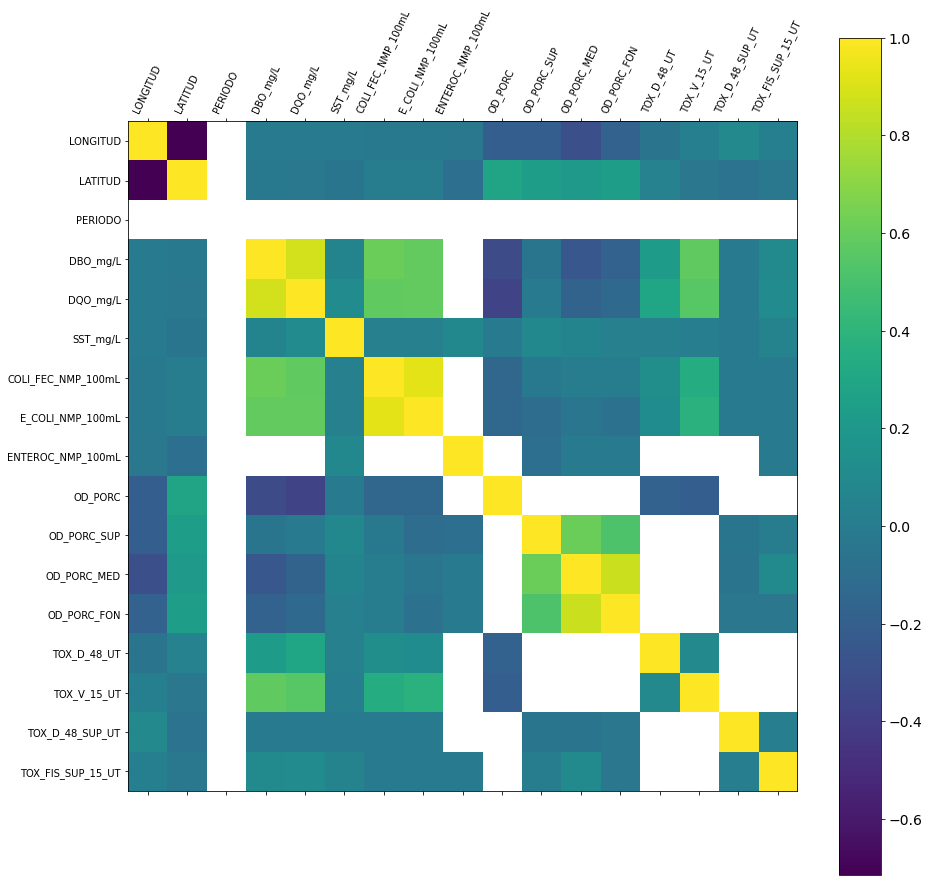

In [27]:
f = plt.figure(figsize=(15, 15))
plt.matshow(dfForCleansingSuperficiales.corr(), fignum=f.number)
plt.xticks(range(dfForCleansingSuperficiales.select_dtypes(['number']).shape[1]), dfForCleansingSuperficiales.select_dtypes(['number']).columns, fontsize=10, rotation=65)
plt.yticks(range(dfForCleansingSuperficiales.select_dtypes(['number']).shape[1]), dfForCleansingSuperficiales.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

<font color="darkblue" size=4> También podemos determinar que la variable de Periodo solo cuenta con un valor, procedemos a eliminarla

In [28]:
dfForCleansingSuperficiales.drop('PERIODO', inplace=True, axis=1)

<font color="darkblue" size=4> <b> Nota Importante: </b>
<br> Las siguientes columnas tienen un correlación directa, en cada par una columna se refiere al valor o lectura de una métrica, y la segunda columna se refiere a la categorización de dicho valor en una escala definida. Por lo tanto, ambas columnas refieren la misma información. <br>
Con la intención de dismunir la dimensionalidad generaremos dos datasets para posteriromente medir el rendimiento del modelo. En cada uno de ellos elimaneremos ya sea las columnas de los valores de la muestra o las columnas referentes a su categoría.
El objetivo sería reducir la complejidad para la convergencia y procesamiento.

| Variable con medición  | Variable categórica |
|---|---|
| DBO_mg/L | CALIDAD_DBO |
| DQO_mg/L | CALIDAD_DQO |
| SST_mg/L | CALIDAD_SST |
| COLI_FEC_NMP_100mL | CALIDAD_COLI_FEC |
| E_COLI_NMP_100mL | CALIDAD_E_COLI |
| ENTEROC_NMP_100mL | CALIDAD_ENTEROC |
| OD_PORC  | CALIDAD_OD_PORC|
| OD_PORC_SUP | CALIDAD_OD_PORC_SUP |
| OD_PORC_MED | CALIDAD_OD_PORC_MED |
| OD_PORC_FON | CALIDAD_OD_PORC_FON |
| TOX_D_48_UT | CALIDAD_TOX_D_48 |
| TOX_V_15_UT | CALIDAD_TOX_V_15 |
| TOX_D_48_SUP_UT | CALIDAD_TOX_D_48_SUP |
| TOX_D_48_FON_UT | CALIDAD_TOX_D_48_FON |
| TOX_FIS_SUP_15_UT | CALIDAD_TOX_FIS_SUP_15 |
| TOX_FIS_FON_15_UT | CALIDAD_TOX_FIS_FON_15 |

In [29]:
dfSuperficialesCategoricas = dfForCleansingSuperficiales.copy()
dfSuperficialesCategoricas.drop('DBO_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('DQO_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('SST_mg/L', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('COLI_FEC_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('E_COLI_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('ENTEROC_NMP_100mL', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_SUP', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_MED', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('OD_PORC_FON', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_D_48_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_V_15_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_D_48_SUP_UT', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('TOX_FIS_SUP_15_UT', inplace=True, axis=1)


In [30]:
dfSuperficialesCategoricas.dtypes

CLAVE                      object
LONGITUD                  float64
LATITUD                   float64
CALIDAD_DBO                object
CALIDAD_DQO                object
CALIDAD_SST                object
CALIDAD_COLI_FEC           object
CALIDAD_E_COLI             object
CALIDAD_ENTEROC            object
CALIDAD_OD_PORC            object
CALIDAD_OD_PORC_SUP        object
CALIDAD_OD_PORC_MED        object
CALIDAD_OD_PORC_FON        object
CALIDAD_TOX_D_48           object
CALIDAD_TOX_V_15           object
CALIDAD TOX_D_48_SUP       object
CALIDAD_TOX_FIS_SUP_15     object
SEMAFORO                   object
CONTAMINANTES              object
CUMPLE_CON_DBO             object
CUMPLE_CON_DQO             object
CUMPLE_CON_SST             object
CUMPLE_CON_CF              object
CUMPLE_CON_E_COLI          object
CUMPLE_CON_ENTEROC         object
CUMPLE_CON_OD              object
CUMPLE_CON_TOX             object
GRUPO                      object
dtype: object

In [31]:
dfSuperficialesCategoricas.head(4)

,CLAVE,LONGITUD,LATITUD,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,NaN,NaN,Aceptable,NaN,NaN,NaN,NaN,No Toxico,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,NaN,NaN,Excelente,NaN,NaN,NaN,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [32]:
dfSuperficialesContinuas = dfForCleansingSuperficiales.copy()
dfSuperficialesContinuas.drop('CALIDAD_DBO', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_DQO', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_SST', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_COLI_FEC', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_E_COLI', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_ENTEROC', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_OD_PORC', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_OD_PORC_SUP', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_OD_PORC_MED', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_OD_PORC_FON', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_TOX_D_48', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_TOX_V_15', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD_TOX_FIS_SUP_15', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CALIDAD TOX_D_48_SUP', inplace=True, axis=1)



In [33]:
dfSuperficialesContinuas.dtypes

CLAVE                  object
LONGITUD              float64
LATITUD               float64
DBO_mg/L              float64
DQO_mg/L              float64
SST_mg/L              float64
COLI_FEC_NMP_100mL    float64
E_COLI_NMP_100mL      float64
ENTEROC_NMP_100mL     float64
OD_PORC               float64
OD_PORC_SUP           float64
OD_PORC_MED           float64
OD_PORC_FON           float64
TOX_D_48_UT           float64
TOX_V_15_UT           float64
TOX_D_48_SUP_UT       float64
TOX_FIS_SUP_15_UT     float64
SEMAFORO               object
CONTAMINANTES          object
CUMPLE_CON_DBO         object
CUMPLE_CON_DQO         object
CUMPLE_CON_SST         object
CUMPLE_CON_CF          object
CUMPLE_CON_E_COLI      object
CUMPLE_CON_ENTEROC     object
CUMPLE_CON_OD          object
CUMPLE_CON_TOX         object
GRUPO                  object
dtype: object

In [34]:
dfSuperficialesContinuas.head(4)

,CLAVE,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,6.0,54.08,13.7500,1162.0,98.0,NaN,NaN,46.8,NaN,NaN,NaN,NaN,1.0,1.0,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,NaN,NaN,10.0000,NaN,NaN,20.0,NaN,92.0,95.4,92.2,NaN,NaN,NaN,1.0,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,NaN,NaN,10.0000,NaN,NaN,3.0,NaN,92.0,95.4,92.2,NaN,NaN,NaN,1.0,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,NaN,NaN,13.9667,NaN,NaN,3.0,NaN,NaN,NaN,86.7,NaN,NaN,NaN,1.0,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


<font color="darkblue" size=4> Vamos a definir un imputer para ser usado posteriormente en un pipeline junto a algun modelo. Sin embargo en este momento imputaremos los valores directamente con *fillna()* , poblando los valores faltantes con una nueva categoria de "sin medida".

In [35]:
#vamos a imputar los valores faltantes en las variables categoricos
columnasCategoricas = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC',
                       'CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP',
                       'CALIDAD_TOX_FIS_SUP_15','CONTAMINANTES']
imputerCategoricas = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Sin medida')

columnasContinuas = ['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC',
                     'OD_PORC_SUP','OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT' ]
imputerContinuas = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)                     

In [36]:
#definicion del column transformer
transformCategoricas = ColumnTransformer([("imputerCat", imputerCategoricas, columnasCategoricas)])
transformContinuas = ColumnTransformer([("imputerCon", imputerContinuas, columnasContinuas)])

In [37]:
dfSuperficialesCategoricas['CALIDAD_DBO'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_DQO'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_SST'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_COLI_FEC'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_E_COLI'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_ENTEROC'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_OD_PORC'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_OD_PORC_SUP'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_OD_PORC_MED'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_OD_PORC_FON'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_TOX_D_48'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_TOX_V_15'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD TOX_D_48_SUP'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CALIDAD_TOX_FIS_SUP_15'].fillna('Sin medida', inplace = True)
dfSuperficialesCategoricas['CONTAMINANTES'].fillna('Sin medida', inplace = True)

In [38]:
dfSuperficialesCategoricas.head(4)

,CLAVE,LONGITUD,LATITUD,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,Sin medida,Sin medida,Aceptable,Sin medida,Sin medida,Sin medida,Sin medida,No Toxico,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


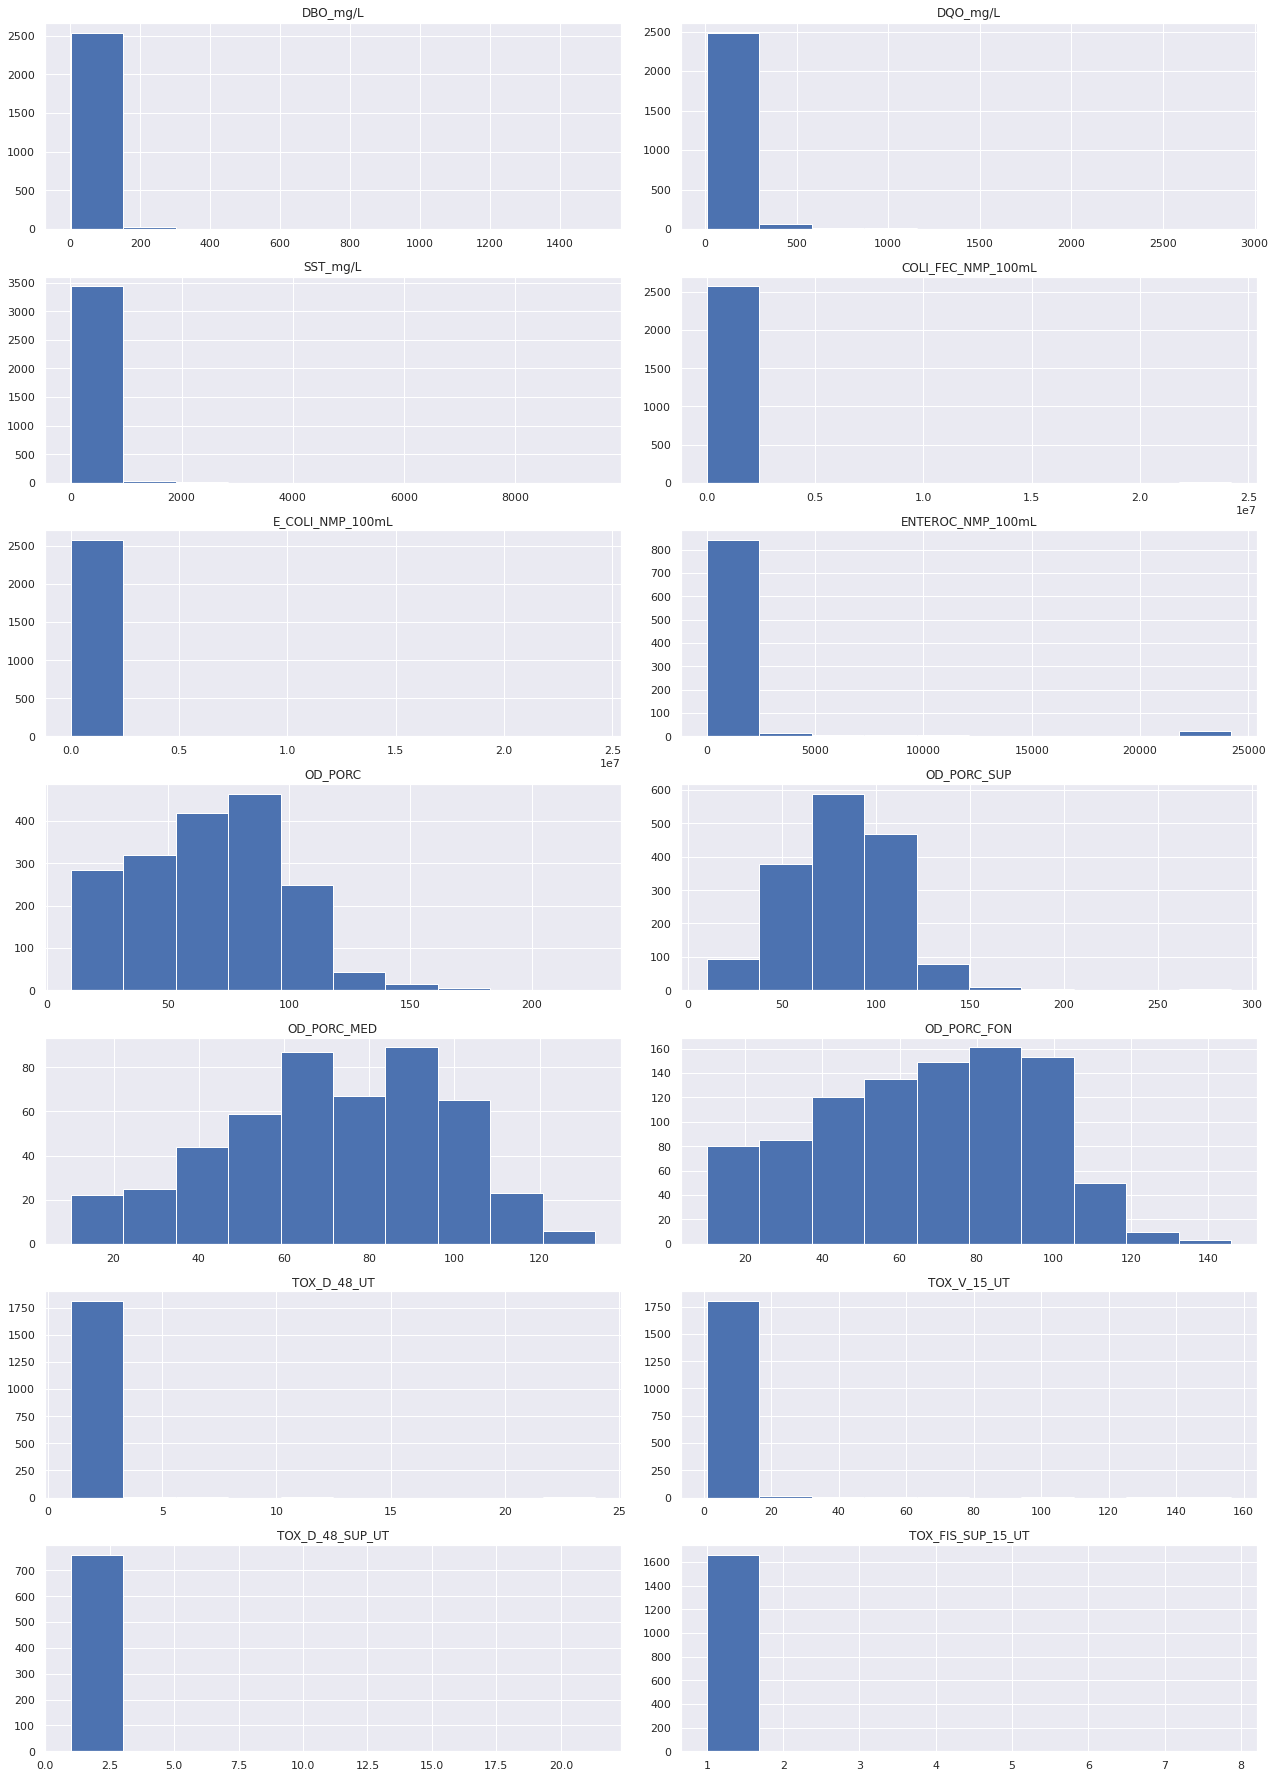

In [39]:
sns.set(rc={'figure.figsize':(18,25)})
fig, axes = plt.subplots(7,2)
fig.tight_layout(pad=2.0)

columns = ['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC',
                     'OD_PORC_SUP','OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT' ]
counter = 1
for column in columns:
  plt.subplot(7,2,counter)
  plt.title(column) 
  counter = counter+1
  plt.hist(dfSuperficialesContinuas[column])

plt.show()

In [40]:
dfSuperficialesContinuas['DBO_mg/L'].fillna(-1, inplace = True)
dfSuperficialesContinuas['DQO_mg/L'].fillna(-1, inplace = True)
dfSuperficialesContinuas['SST_mg/L'].fillna(-1, inplace = True)
dfSuperficialesContinuas['COLI_FEC_NMP_100mL'].fillna(-1, inplace = True)
dfSuperficialesContinuas['E_COLI_NMP_100mL'].fillna(-1, inplace = True)
dfSuperficialesContinuas['ENTEROC_NMP_100mL'].fillna(-1, inplace = True)
dfSuperficialesContinuas['OD_PORC'].fillna(-1, inplace = True)
dfSuperficialesContinuas['OD_PORC_SUP'].fillna(-1, inplace = True)
dfSuperficialesContinuas['OD_PORC_MED'].fillna(-1, inplace = True)
dfSuperficialesContinuas['OD_PORC_FON'].fillna(-1, inplace = True)
dfSuperficialesContinuas['TOX_D_48_UT'].fillna(-1, inplace = True)
dfSuperficialesContinuas['TOX_V_15_UT'].fillna(-1, inplace = True)
dfSuperficialesContinuas['TOX_D_48_SUP_UT'].fillna(-1, inplace = True)
dfSuperficialesContinuas['TOX_FIS_SUP_15_UT'].fillna(-1, inplace = True)
dfSuperficialesContinuas['CONTAMINANTES'].fillna('Sin medida', inplace = True)

In [41]:
dfSuperficialesContinuas.head(4)

,CLAVE,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,6.0,54.08,13.7500,1162.0,98.0,-1.0,-1.0,46.8,-1.0,-1.0,-1.0,-1.0,1.0,1.0,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,-1.0,-1.00,10.0000,-1.0,-1.0,20.0,-1.0,92.0,95.4,92.2,-1.0,-1.0,-1.0,1.0,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,-1.0,-1.00,10.0000,-1.0,-1.0,3.0,-1.0,92.0,95.4,92.2,-1.0,-1.0,-1.0,1.0,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,-109.88604,22.89609,-1.0,-1.00,13.9667,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,86.7,-1.0,-1.0,-1.0,1.0,Verde,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


<font color="darkblue" size=4> Graficar variables categóricas

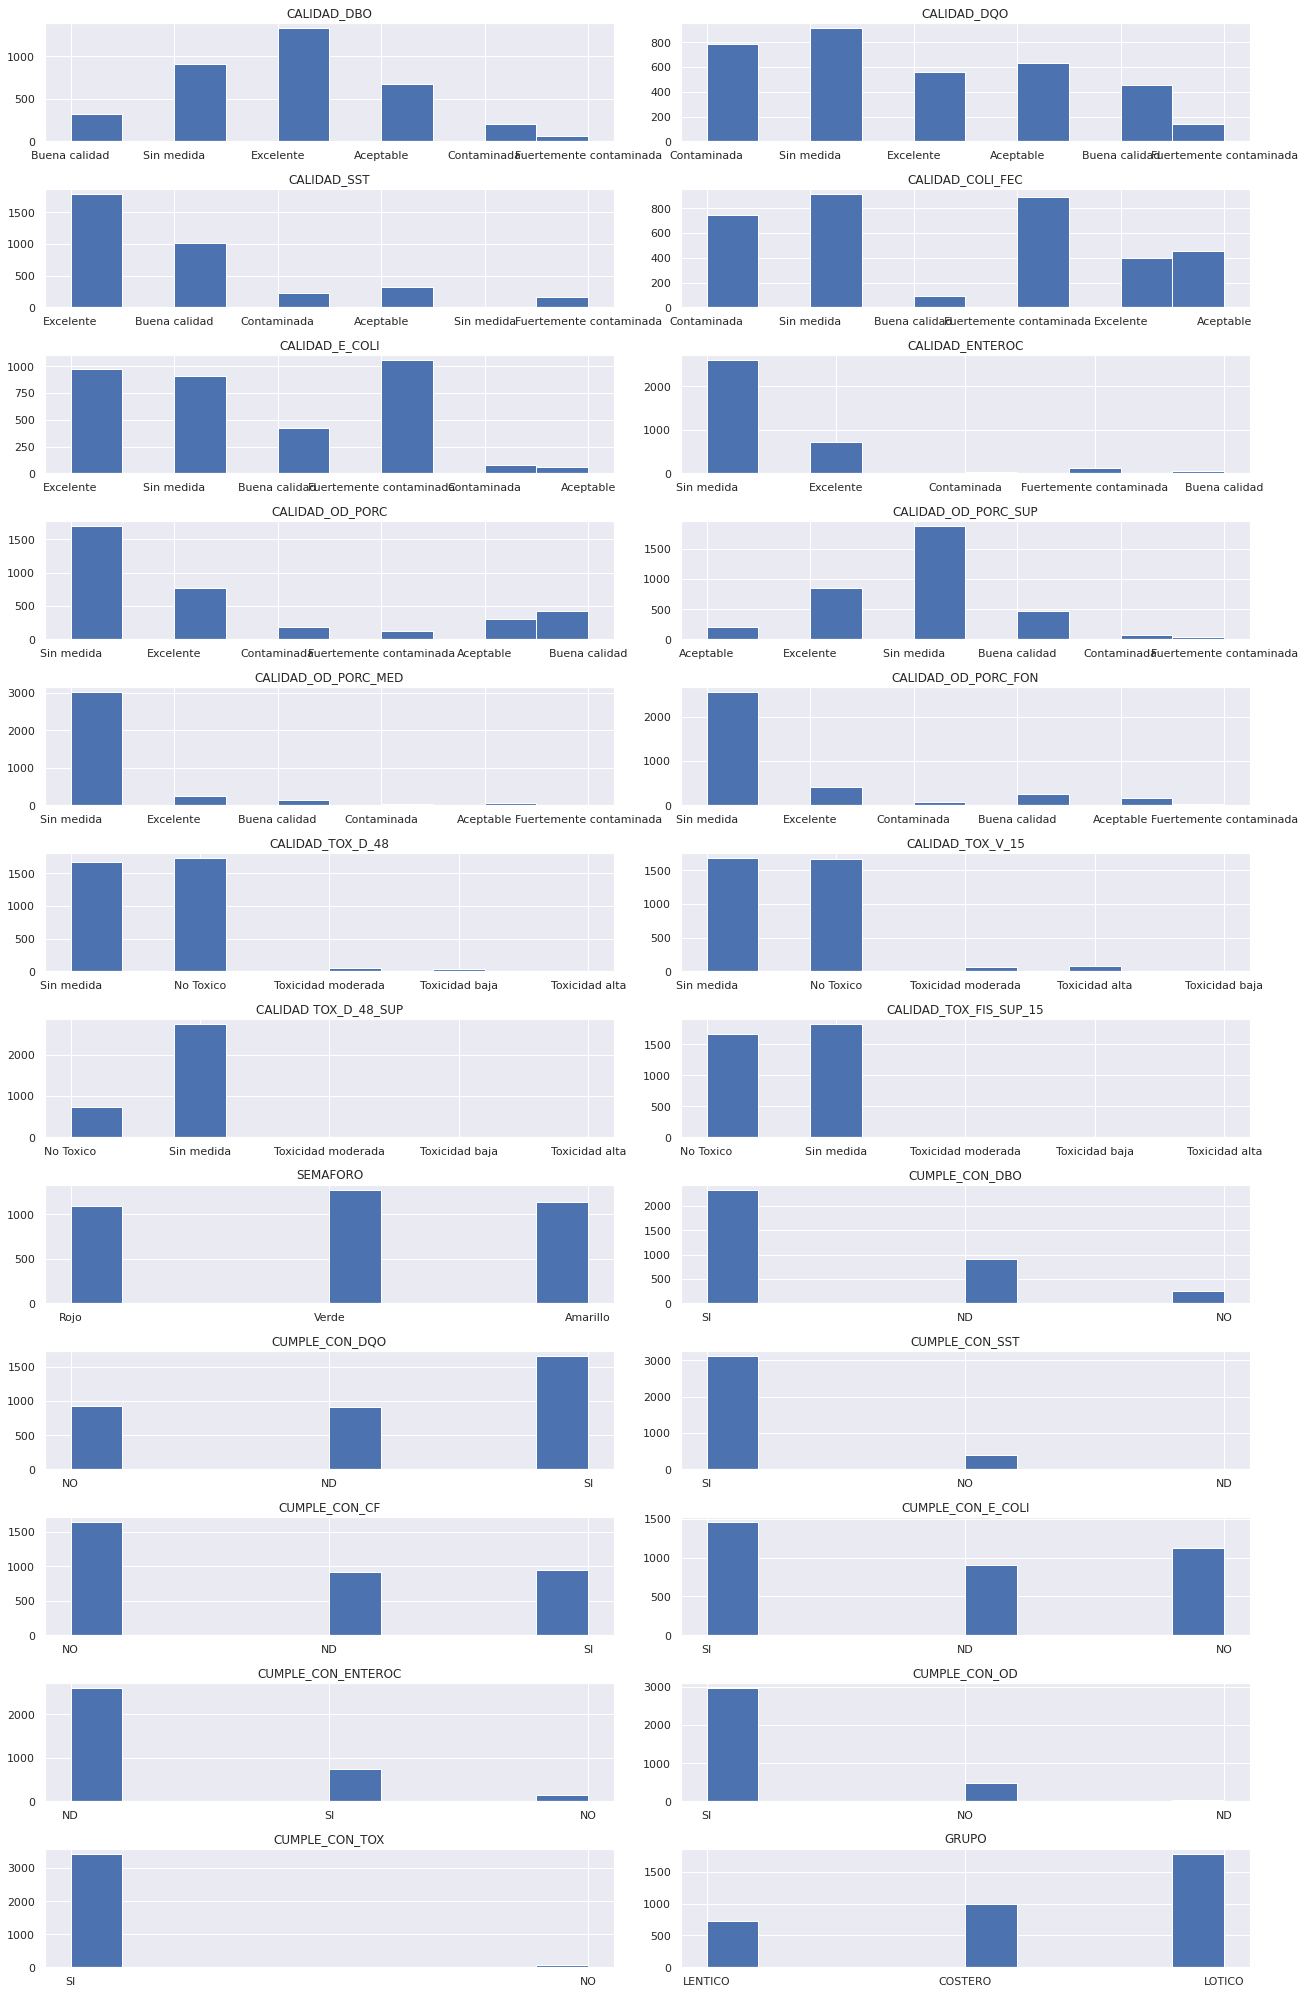

In [42]:

sns.set(rc={'figure.figsize':(18,28)})
fig, axes = plt.subplots(12,2)
fig.tight_layout(pad=2.0)

columns = [ 'CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD_SST', 'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC',
       'CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_FIS_SUP_15', 'SEMAFORO', 'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO',
       'CUMPLE_CON_SST','CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC','CUMPLE_CON_OD', 'CUMPLE_CON_TOX',
       'GRUPO']
counter = 1
for column in columns:
  plt.subplot(12,2,counter)
  plt.title(column) 
  counter = counter+1
  plt.hist(dfSuperficialesCategoricas[column])

plt.show()

<font color="darkblue" size=4> Graficar variables continuas después de imputar

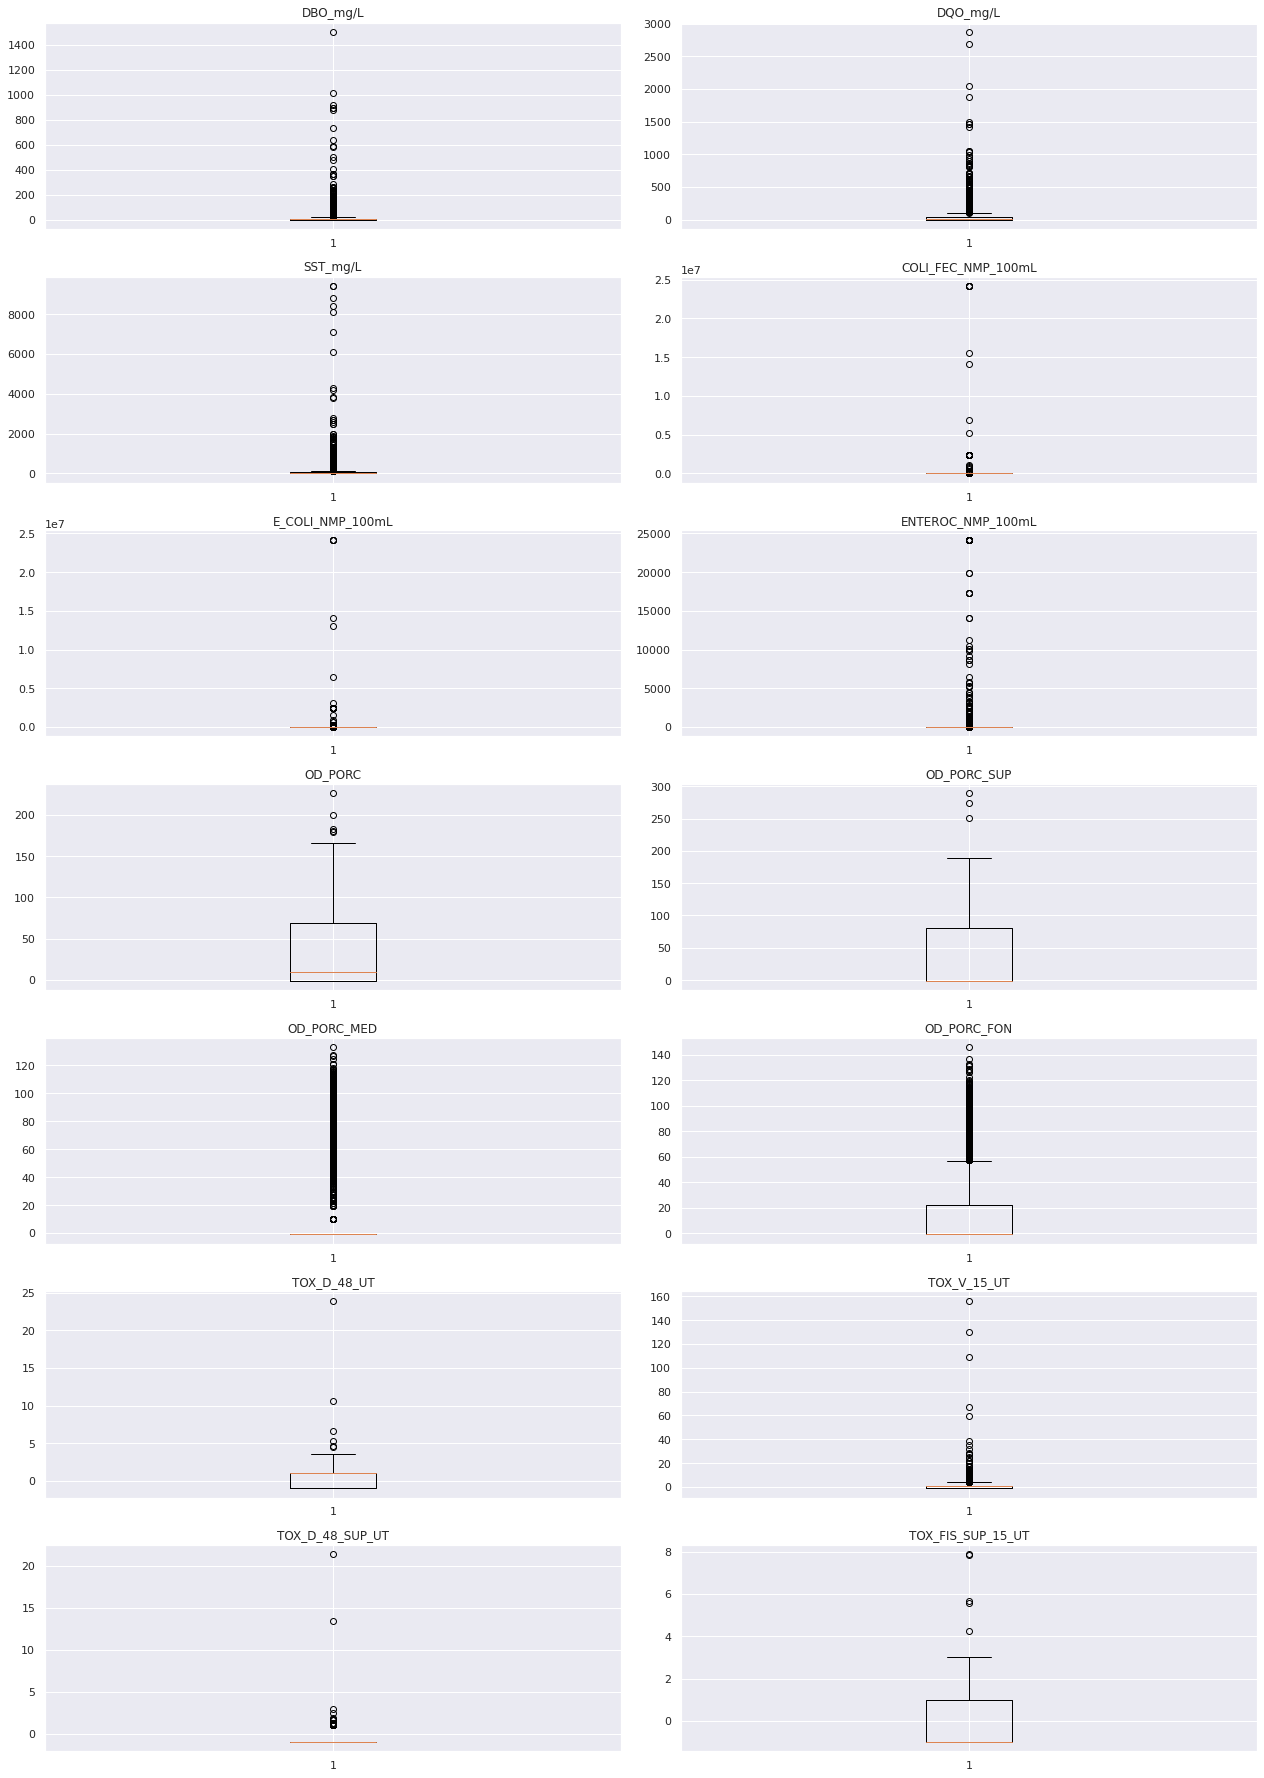

In [43]:

sns.set(rc={'figure.figsize':(18,25)})
fig, axes = plt.subplots(7,2)
fig.tight_layout(pad=2.0)

columns = ['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC',
                     'OD_PORC_SUP','OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT' ]
counter = 1
for column in columns:
  plt.subplot(7,2,counter)
  plt.title(column) 
  counter = counter+1
  plt.boxplot(dfSuperficialesContinuas[column])

plt.show()

### Construcción de data frames de longitud y latitud para graficar

In [44]:
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
superficialesLatLon = dfForCleansingSuperficiales.copy()
superficialesLatLon = superficialesLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
superficialesLatLon["Coordinates"] = list(zip(superficialesLatLon.LONGITUD, superficialesLatLon.LATITUD))
superficialesLatLon["Coordinates"] = superficialesLatLon["Coordinates"].apply(Point)
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
#subterraneasLatLon = dfUnprocessedSubterraneas.copy()
#subterraneasLatLon = subterraneasLatLon[['CLAVE','LATITUD','LONGITUD','SEMAFORO']]
#subterraneasLatLon["Coordinates"] = list(zip(subterraneasLatLon.LONGITUD, subterraneasLatLon.LATITUD))
#subterraneasLatLon["Coordinates"] = subterraneasLatLon["Coordinates"].apply(Point)

## <font color='darkorange'>Definir componentes para grafica de México</font>


In [45]:
def graphCuerposDeAgua(main_clustering, main_shadow, red_clustering, yellow_clustering, green_clustering, cuerposDeAgua):
  #calculate Kmeans
  #df por semaforo
  dfAmarillo = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Amarillo'].copy()
  dfAmarillo = dfAmarillo[['LATITUD','LONGITUD']]
  dfRojo     = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Rojo'].copy()
  dfRojo     = dfRojo[['LATITUD','LONGITUD']]
  dfVerde    = cuerposDeAgua.loc[cuerposDeAgua['SEMAFORO'] == 'Verde'].copy()
  dfVerde    = dfVerde[['LATITUD','LONGITUD']]
  dfFull     = cuerposDeAgua[['LATITUD','LONGITUD']].copy()
  
  kmeans = KMeans(n_clusters=main_clustering)
  #obtener clusters generales
  kmeans.fit(dfFull)
  full_kmeans = kmeans.predict(dfFull)
  full_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfFull = pd.DataFrame(full_centers)
  dfFull.columns = ["latitude","longitude"]
  dfFull["Coordinates"] = list(zip(dfFull.longitude, dfFull.latitude))
  dfFull["Coordinates"] = dfFull["Coordinates"].apply(Point)
  gdfFull = gpd.GeoDataFrame(dfFull, geometry="Coordinates")


  #obtener amarillos
  kmeans = KMeans(n_clusters=yellow_clustering)
  kmeans.fit(dfAmarillo)
  yellow_kmeans = kmeans.predict(dfAmarillo)
  yellow_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfYellow = pd.DataFrame(yellow_centers)
  dfYellow.columns = ["latitude","longitude"]
  dfYellow["Coordinates"] = list(zip(dfYellow.longitude, dfYellow.latitude))
  dfYellow["Coordinates"] = dfYellow["Coordinates"].apply(Point)
  gdfYellowKmeans = gpd.GeoDataFrame(dfYellow, geometry="Coordinates")

  #obtener verdes
  kmeans = KMeans(n_clusters=green_clustering)
  kmeans.fit(dfVerde)
  red_kmeans = kmeans.predict(dfVerde)
  green_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfGreen  = pd.DataFrame(green_centers)
  dfGreen.columns = ["latitude","longitude"]
  dfGreen["Coordinates"] = list(zip(dfGreen.longitude, dfGreen.latitude))
  dfGreen["Coordinates"] = dfGreen["Coordinates"].apply(Point)
  gdfGreenKmeans = gpd.GeoDataFrame(dfGreen, geometry="Coordinates")
  
  #obtener rojos
  kmeans = KMeans(n_clusters=red_clustering)
  kmeans.fit(dfRojo)
  green_kmeans = kmeans.predict(dfRojo)
  red_centers = kmeans.cluster_centers_
  #centers to geopandas
  dfRed    = pd.DataFrame(red_centers)
  dfRed.columns = ["latitude","longitude"]
  dfRed["Coordinates"] = list(zip(dfRed.longitude, dfRed.latitude))
  dfRed["Coordinates"] = dfRed["Coordinates"].apply(Point)
  gdfRedKmeans = gpd.GeoDataFrame(dfRed, geometry="Coordinates")

  ###dfKmeans = pd.DataFrame(centers)
  ###dfKmeans.columns = ["latitude","longitude"]
  ###dfKmeans["Coordinates"] = list(zip(dfKmeans.longitude, dfKmeans.latitude))
  ###dfKmeans["Coordinates"] = dfKmeans["Coordinates"].apply(Point)
  #prepare traget stores data.
  dfCuerposDeAgua = cuerposDeAgua.copy()
  dfCuerposDeAgua["Coordinates"] = list(zip(dfCuerposDeAgua.LONGITUD, dfCuerposDeAgua.LATITUD))
  dfCuerposDeAgua["Coordinates"] = dfCuerposDeAgua["Coordinates"].apply(Point)
  gdfCuerposDeAgua = gpd.GeoDataFrame(dfCuerposDeAgua, geometry="Coordinates")
  #gdfKmeans = gpd.GeoDataFrame(dfKmeans, geometry="Coordinates")
  #gTargetStores = gpd.GeoDataFrame(dfStores, geometry="Coordinates")
  

  #grafica de cuerpos de agua.
  fig, ax = plt.subplots(figsize=(20,14))

  ax.set_xlabel('longitude')
  ax.set_ylabel('latitude')

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  #MAPA MEXICO
  mx.plot(ax=ax, k=5, alpha=0.7)
  #CUERPOS DE AGUA
  #semaforo color map
  semaforo_cmap = {'Amarillo': 'yellow', 'Verde': 'limegreen', 'Rojo' : 'red'}
  cmap_s = colors.ListedColormap([semaforo_cmap[b] for b in gdfCuerposDeAgua.SEMAFORO.unique()])
  gdfCuerposDeAgua.plot(ax=ax, alpha = 1.0, column='SEMAFORO', cmap=cmap_s, legend=True)


  fig2, ax2 = plt.subplots(figsize=(20,14))
  #GRAFICA DE KMEANS
  mx.plot(ax=ax2, k=5, alpha=0.5)
  gdfRedKmeans.plot(ax=ax2, color='red', alpha =1.0, markersize=250, marker="X", legend=True, label='Red clusters')
  gdfYellowKmeans.plot(ax=ax2, color='yellow', alpha =1.0, markersize=250, marker="H", legend=True, label='Yellow clusters')
  gdfGreenKmeans.plot(ax=ax2, color='limegreen', alpha =1.0, markersize=250, marker="o", legend=True, label='Green clusters')
  gdfFull.plot(ax=ax2, color='purple', alpha =0.3, markersize=main_shadow, marker="o", legend=True, label='K-means clusters')
  #ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., markerscale=.3)
  lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=15,facecolor='lightgray')
  lgnd.legendHandles[0]._sizes = [30]
  lgnd.legendHandles[1]._sizes = [30]
  lgnd.legendHandles[2]._sizes = [30]
  lgnd.legendHandles[3]._sizes = [30]
  

<font color="darkblue" size=4> Veamos un baseline de 10 clusters.
- La primera gráfica muestra las cuerpos de agua usando un código de color dependiendo del semáforo.
- La segunda gráfica muestra áreas circualres en color morado donde se ubicarían los clusters. También añadimos -para tener una referencia visual de clusters por categoría, con la intención de identificar si los clusters definidos estan capturando un semáforo-categoría de forma principal.

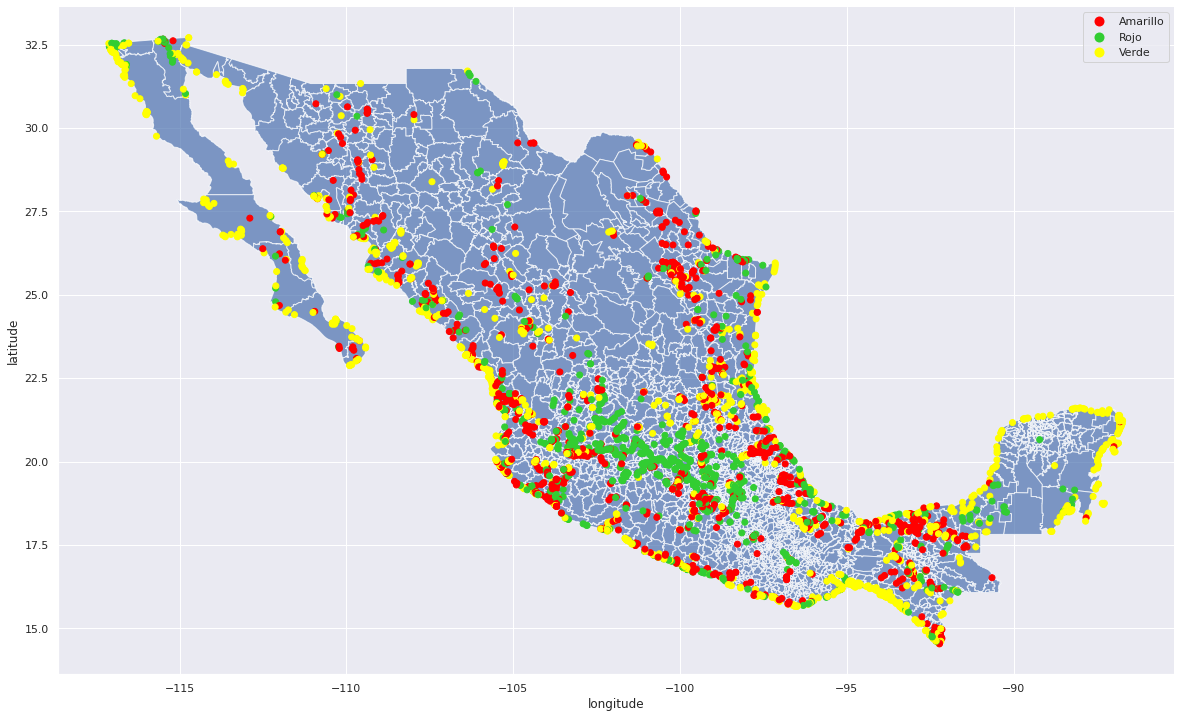

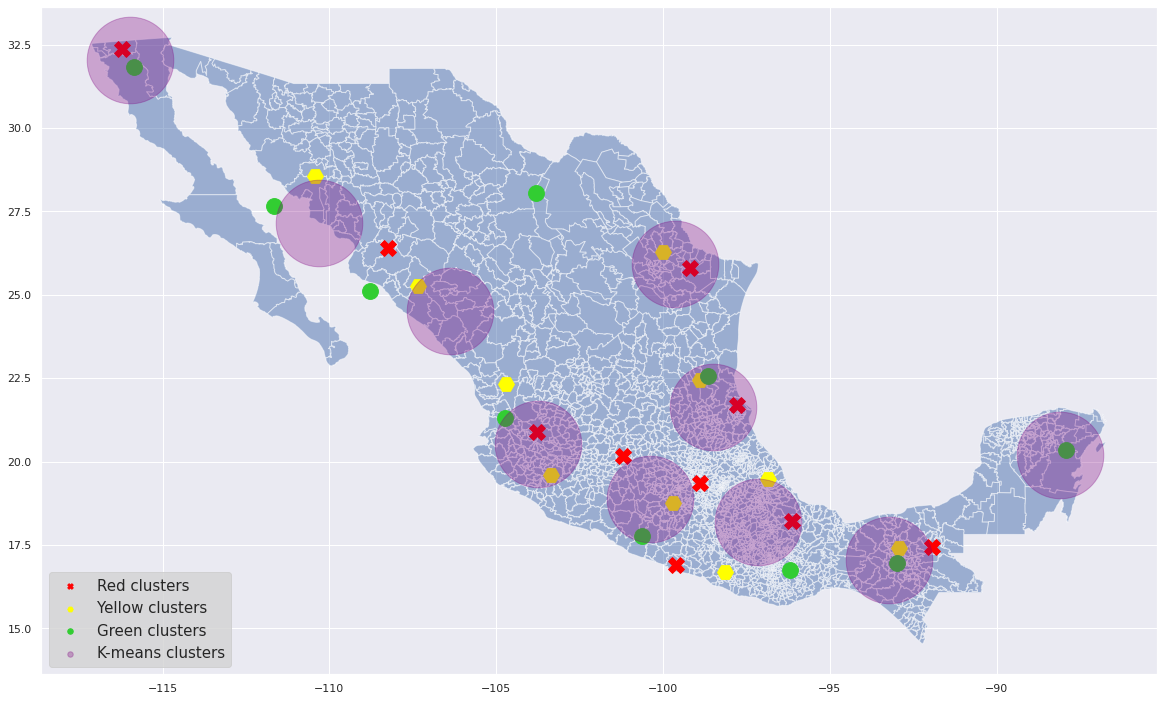

In [46]:
graphCuerposDeAgua(10, 7500, 10, 10, 10, superficialesLatLon)

<font color="darkblue" size=4> Vamos a utilizar método de elbow y silhoutte para determinar cuantos clusters sería apropiado usar. Definimos una función para gráficar cada uno de los métodos.

In [47]:

def graphSilhouetteanAndElbowScoreInRange(lowerLimit,upperLimit,storesLatLon):
  range_n_clusters = range(lowerLimit,upperLimit)
  #--- silhoutte --------------------------------------------
  silhouette_avg = []
  for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(storesLatLon, cluster_labels))

  #--- elbow------------------------------------------------  
  Sum_of_squared_distances = []
  K = range(lowerLimit,upperLimit)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(storesLatLon)
    Sum_of_squared_distances.append(kmeans.inertia_)


  sns.set(rc={'figure.figsize':(20,8)})
  fig, axes = plt.subplots(1,2)

  fig.tight_layout(pad=2.0)
  plt.subplot(1,2,1)
  plt.plot(range_n_clusters,silhouette_avg,'bx-')
  plt.xlabel('Number of clusters') 
  plt.ylabel('Silhouette score') 
  plt.title('Silhouette analysis For Optimal k')

  plt.subplot(1,2,2)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Number of clusters') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')

  plt.show()

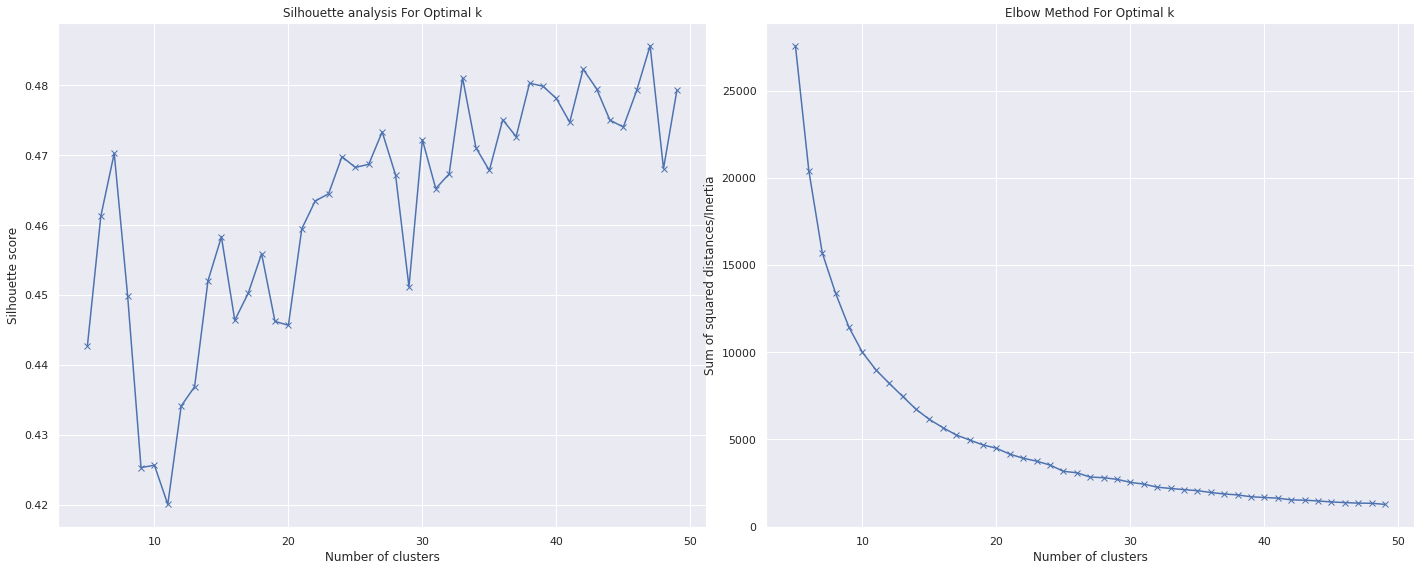

In [48]:
graphSilhouetteanAndElbowScoreInRange(5,50,superficialesLatLon[['LATITUD','LONGITUD']])

<font color="darkblue" size=4> Conforme a las graficas, usaremos 41 clusters. Nos podemos dar cuenta que aun con 40 clusters, existen muestras de mas de un tipo en cada cluster.
Considerando ese numéro de clusters no podríamos decir que existe una relación con el semáforo. Posiblmente tendríamos que extender significativamente el número de clusters para poder lograr que exista una relación con el semáforo del cuerpo de agua.

<font color="darkblue" size=4> Considero que para poder generar un mapa de clusters que representen mejor una relación hacía el semñaforo, podríamos intentar segmentar la muestra por regiones geográficas.

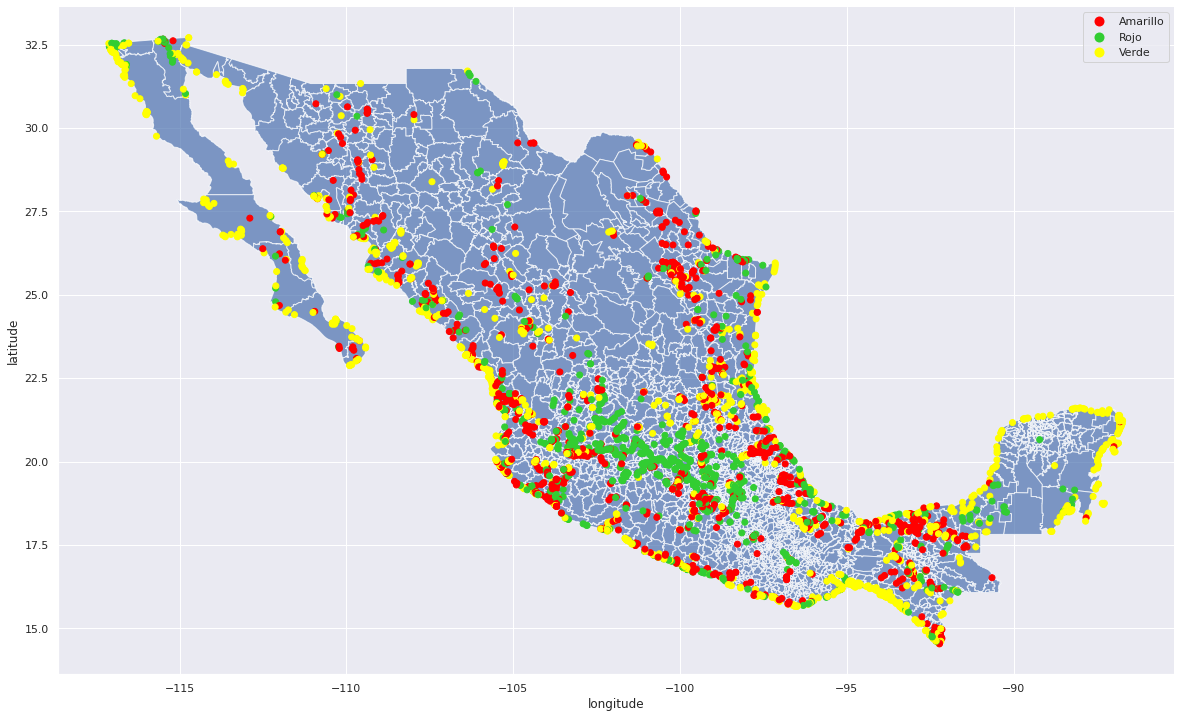

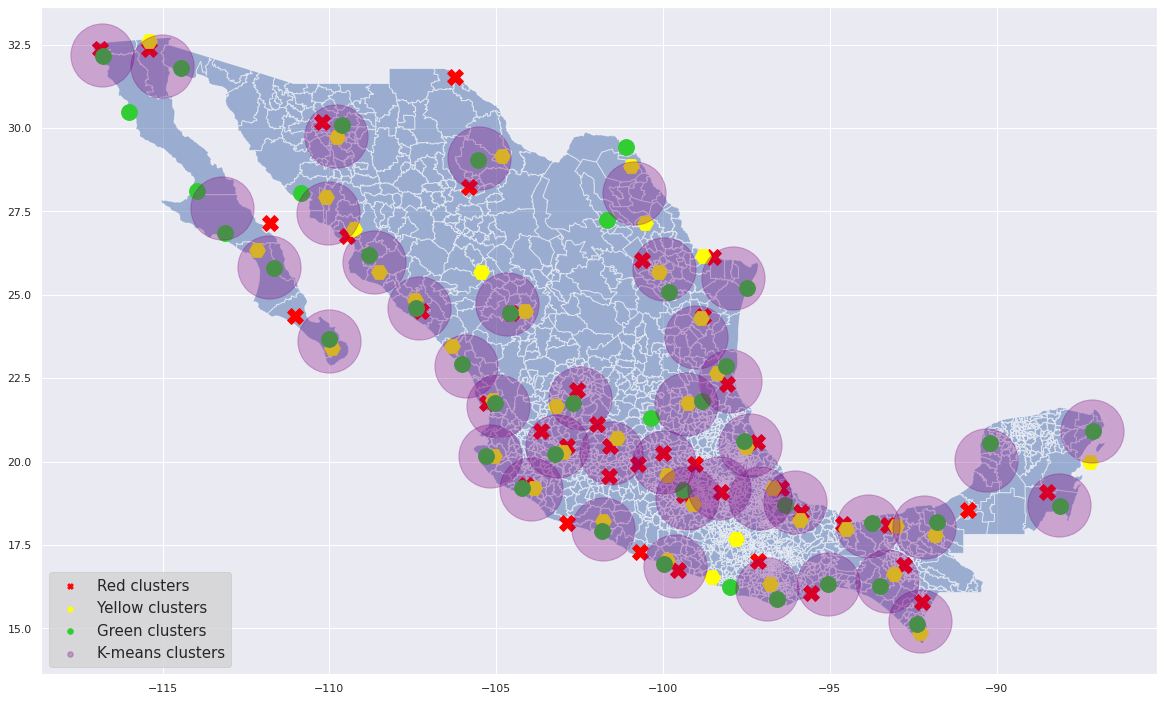

In [49]:
graphCuerposDeAgua(41, 4000, 41, 41, 41, superficialesLatLon)

# <font color='red'>Entrega 2

In [104]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import  OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## <font color='darkorange'> Encoding del semáforo (label encoding)

In [51]:
#obtener valores para el encoding del semaforo
valoresSemaforo = dfSuperficialesCategoricas.SEMAFORO.unique()
valoresSemaforo

array(['Rojo', 'Verde', 'Amarillo'], dtype=object)

In [53]:
#instanciar label encoder y entrenar con nuestros valores de semaforo
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(valoresSemaforo)

LabelEncoder()

In [54]:
#podemos ver nuestras clases listadas
list(labelEncoder.classes_)

['Amarillo', 'Rojo', 'Verde']

In [55]:
#aplicamos la trasnformacion a nuestra variable de salida en nuestros dataframes.
#transform hace encoding, inverse_transform hace decoding
dfSuperficialesCategoricas.SEMAFORO = labelEncoder.transform(dfSuperficialesCategoricas.SEMAFORO)
dfSuperficialesContinuas.SEMAFORO = labelEncoder.transform(dfSuperficialesContinuas.SEMAFORO)

In [56]:
dfSuperficialesCategoricas.head(3)

,CLAVE,LONGITUD,LATITUD,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,Sin medida,Sin medida,Aceptable,Sin medida,Sin medida,Sin medida,Sin medida,No Toxico,No Toxico,1,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,2,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,Sin medida,Sin medida,Excelente,Sin medida,Sin medida,Excelente,Sin medida,Excelente,Excelente,Excelente,Sin medida,Sin medida,Sin medida,No Toxico,2,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [57]:
dfSuperficialesContinuas.head(3)

,CLAVE,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,-102.33911,22.24730,6.0,54.08,13.75,1162.0,98.0,-1.0,-1.0,46.8,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,-109.84290,22.90473,-1.0,-1.00,10.00,-1.0,-1.0,20.0,-1.0,92.0,95.4,92.2,-1.0,-1.0,-1.0,1.0,2,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,-109.86442,22.89880,-1.0,-1.00,10.00,-1.0,-1.0,3.0,-1.0,92.0,95.4,92.2,-1.0,-1.0,-1.0,1.0,2,Sin medida,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


## <font color='darkorange'> Train-test split

Realizamos una partición de los datos, entrenamiento del 85% y 15% de prueba.</br>

In [58]:
Y_cat = dfSuperficialesCategoricas.SEMAFORO
Y_con = dfSuperficialesContinuas.SEMAFORO

dfSuperficialesCategoricas.drop('SEMAFORO', inplace=True, axis=1)
dfSuperficialesCategoricas.drop('CLAVE', inplace=True, axis=1)
dfSuperficialesContinuas.drop('SEMAFORO', inplace=True, axis=1)
dfSuperficialesContinuas.drop('CLAVE', inplace=True, axis=1)

X_cat = dfSuperficialesCategoricas
X_con = dfSuperficialesContinuas

X_cat_train, X_cat_val, y_cat_train, y_cat_val = train_test_split(X_cat, Y_cat, train_size=0.80, random_state=0)
X_con_train, X_con_val, y_con_train, y_con_val = train_test_split(X_con, Y_con, train_size=0.80, random_state=0)

In [59]:
print('Datafram de variables categoricas')
print('Tamaño conjunto de entrenamiento:', X_cat_train.shape)
print('Tamaño conjunto de validacion:',X_cat_val.shape)

Datafram de variables categoricas
Tamaño conjunto de entrenamiento: (2794, 26)
Tamaño conjunto de validacion: (699, 26)


In [60]:
print('Datafram de variables continuas')
print('Tamaño conjunto de entrenamiento:', X_con_train.shape)
print('Tamaño conjunto de entrenamiento:', X_con_val.shape)

Datafram de variables continuas
Tamaño conjunto de entrenamiento: (2794, 26)
Tamaño conjunto de entrenamiento: (699, 26)


In [61]:
#label encoding de variables cateogricas
labelEncodingPipeline = Pipeline(steps = [('labelEncoding', OrdinalEncoder( dtype=np.str_, handle_unknown='use_encoded_value', unknown_value=-1) )])
dfCatCategoricas = ['CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD_SST', 'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC','CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED',
       'CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15', 'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_FIS_SUP_15', 'CONTAMINANTES','CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST',
       'CUMPLE_CON_CF','CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD','CUMPLE_CON_TOX', 'GRUPO']
dfConCategoricas = ['CONTAMINANTES', 'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF',
       'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD','CUMPLE_CON_TOX', 'GRUPO']      

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
featuresCatTransformer = ColumnTransformer(transformers = [('le', labelEncodingPipeline, dfCatCategoricas)],remainder='passthrough')
featuresConTransformer = ColumnTransformer(transformers = [('le', labelEncodingPipeline , dfConCategoricas)],remainder='passthrough')


## <font color='darkorange'> Random Forest -feature importance

In [62]:
randomForestClassifier = RandomForestClassifier(class_weight='balanced', random_state=0)

In [70]:
pipelineRFCat = Pipeline(steps=[('ct',featuresCatTransformer),('randomForest',randomForestClassifier)])
pipelineRFCat.fit(X_cat_train,y_cat_train)
importances = randomForestClassifier.feature_importances_
ftImp = pd.DataFrame(importances).transpose()
ftImp.columns = X_cat_train.columns
ftImp

,LONGITUD,LATITUD,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,0.034414,0.079108,0.002492,0.028605,0.012217,0.034167,0.00497,0.00398,0.002425,0.003174,0.002119,0.005968,0.001536,0.001759,0.296961,0.029872,0.23862,0.005003,0.069921,0.016325,0.080361,0.019822,0.0023,0.008155,0.00743,0.008296


In [72]:
pipelineRFCon = Pipeline(steps=[('ct',featuresConTransformer),('randomForest',randomForestClassifier)])
pipelineRFCon.fit(X_con_train,y_con_train)
importances = randomForestClassifier.feature_importances_
ftImp = pd.DataFrame(importances).transpose()
ftImp.columns = X_con_train.columns
ftImp

,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,0.274245,0.017442,0.142266,0.003564,0.03103,0.008654,0.047836,0.015515,0.001565,0.004315,0.003401,0.003223,0.053413,0.189371,0.006745,0.094167,0.035288,0.035489,0.00545,0.006913,0.001401,0.004864,0.002585,0.002648,0.001721,0.006887


## <font color='darkorange'> Decision Tree -feature importance

In [73]:
decisionTreeClassifier =  DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [78]:
pipelineDTCat = Pipeline(steps=[('ct',featuresCatTransformer),('randomForest',decisionTreeClassifier)])
pipelineDTCat.fit(X_cat_train,y_cat_train)
importances = decisionTreeClassifier.feature_importances_
ftImp = pd.DataFrame(importances).transpose()
ftImp.columns = X_cat_train.columns
ftImp

,LONGITUD,LATITUD,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.016928e-18,0.0,0.0,0.0,0.0,0.501671,0.003381,0.458945,0.0,0.0,0.0,0.033735,0.0,0.002267,0.0,0.0,0.0


In [76]:
pipelineDTCon = Pipeline(steps=[('ct',featuresConTransformer),('randomForest',decisionTreeClassifier)])
pipelineDTCon.fit(X_con_train,y_con_train)
importances = decisionTreeClassifier.feature_importances_
ftImp = pd.DataFrame(importances).transpose()
ftImp.columns = X_con_train.columns
ftImp


,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,0.501671,0.0,0.458945,0.0,0.0,0.0,0.033735,0.0,0.0,0.0,0.0,0.0,0.003381,0.0,0.0,0.0,0.0,0.0,0.0,8.016928e-18,0.0,0.0,0.0,0.0,0.0,0.002267


## <font color='darkorange'> CrossValidate Training

In [96]:

#metrics = {'recall':'recall','precision':'precision'}

randomForestClassifier = RandomForestClassifier(class_weight='balanced', random_state=0)
decisionForestClassifier = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=0)

pipelineRFCat = Pipeline(steps=[('ct',featuresCatTransformer),('randomForest',randomForestClassifier)])
pipelineDTCat = Pipeline(steps=[('ct',featuresCatTransformer),('decisionTree',decisionForestClassifier)])

pipelineRFCon = Pipeline(steps=[('ct',featuresConTransformer),('randomForest',randomForestClassifier)])
pipelineDTCon = Pipeline(steps=[('ct',featuresConTransformer),('decisionTree',decisionForestClassifier)])

crossValidation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

resultsCatTrainingFC = cross_validate(pipelineRFCat, X_cat_train, np.ravel(y_cat_train), cv=crossValidation, return_train_score=True)
resultsCatTrainingDT = cross_validate(pipelineDTCat, X_cat_train, np.ravel(y_cat_train), cv=crossValidation, return_train_score=True)

resultsConTrainingFC = cross_validate(pipelineRFCon, X_con_train, np.ravel(y_con_train), cv=crossValidation, return_train_score=True)
resultsConTrainingDT = cross_validate(pipelineDTCon, X_con_train, np.ravel(y_con_train),  cv=crossValidation, return_train_score=True)

In [97]:
print("Random Forest Classifier - Categorical data set - Test Score: ", np.mean(resultsCatTrainingFC['test_score']))
print("Decision Tree Classifier - Categorical data set - Test Score: ", np.mean(resultsCatTrainingDT['test_score']))
print("Random Forest Classifier - Categorical and continous data set - Test Score: ", np.mean(resultsConTrainingFC['test_score']))
print("Decision Tree Classifier - Categorical and continous data set - Test Score: ", np.mean(resultsConTrainingDT['test_score']))

Random Forest Classifier - Categorical data set - Test Score:  0.9977329802536105
Decision Tree Classifier - Categorical data set - Test Score:  0.9861593603529089
Random Forest Classifier - Categorical and continous data set - Test Score:  0.9976139333978795
Decision Tree Classifier - Categorical and continous data set - Test Score:  0.9861593603529089


## <font color='darkorange'> Classification Reports y Confusion matrices

In [125]:
#graph de confusion matrix
def graphConfusionMatirx(confusionMatrixResult):
  txt = ['Verdaderos Positivo','Falsos Positivos','Falsos Positivos','Falso Negativo','Verdadero Positivo','Falsos Positivos','Falsos Negativos','Falsos Negativos','Verdaderos Positivos']
  frecuencia = ["{0:0.0f}".format(value) for value in confusionMatrixResult.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in confusionMatrixResult.flatten()/np.sum(confusionMatrixResult)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(txt,frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(3,3)
  
  sns.set(rc={'figure.figsize':(10,10)})
  ax = sns.heatmap(confusionMatrixResult, annot=labels, fmt='', cmap='Blues', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

In [126]:
classification_report,
pipelineRFCat.fit(X_cat_train, y_cat_train)
y_hat = pipelineRFCat.predict(X_cat_val)
target_names = [0, 1, 2]
cm = confusion_matrix(y_cat_val, y_hat)
print("Random Forest Classifier - Categorical data set - ")
print(classification_report(y_cat_val, y_hat, labels = target_names))

Random Forest Classifier - Categorical data set - 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       1.00      1.00      1.00       211
           2       1.00      1.00      1.00       267

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699



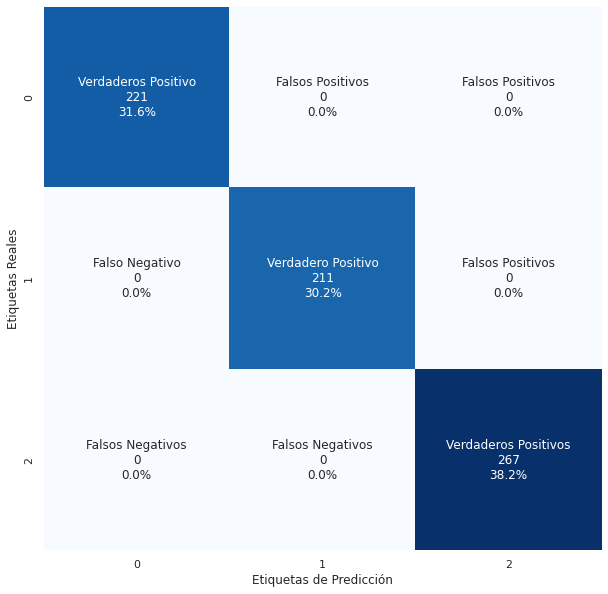

In [127]:
graphConfusionMatirx(cm)

In [128]:
classification_report,
pipelineDTCat.fit(X_cat_train, y_cat_train)
y_hat = pipelineDTCat.predict(X_cat_val)
target_names = [0, 1, 2]
cm = confusion_matrix(y_cat_val, y_hat)
print("Decision Tree Classifier - Categorical data set - ")
print(classification_report(y_cat_val, y_hat, labels = target_names))

Decision Tree Classifier - Categorical data set - 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       221
           1       0.99      1.00      1.00       211
           2       1.00      1.00      1.00       267

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699



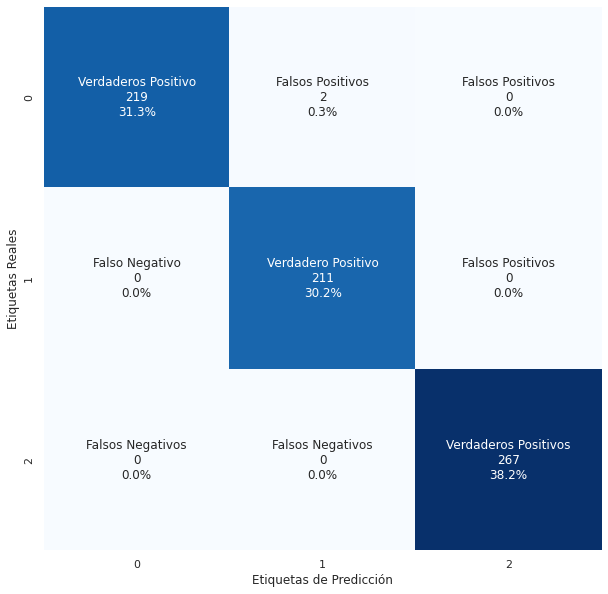

In [129]:
graphConfusionMatirx(cm)

In [134]:
classification_report,
pipelineRFCon.fit(X_con_train, y_con_train)
y_hat = pipelineRFCon.predict(X_con_val)
target_names = [0, 1, 2]
cm = confusion_matrix(y_con_val, y_hat)
print("Random Forest Classifier - Categorical and continous data set - ")
print(classification_report(y_con_val, y_hat, labels = target_names))

Random Forest Classifier - Categorical and continous data set - 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       1.00      1.00      1.00       211
           2       1.00      1.00      1.00       267

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699



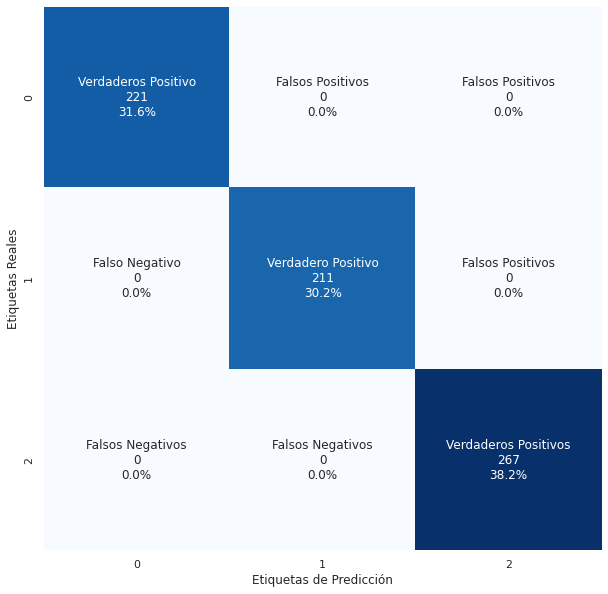

In [135]:
graphConfusionMatirx(cm)

In [136]:
classification_report,
pipelineDTCon.fit(X_con_train, y_cat_train)
y_hat = pipelineDTCon.predict(X_con_val)
target_names = [0, 1, 2]
cm = confusion_matrix(y_con_val, y_hat)
print("Decision Tree Classifier - Categorical and continous data set - ")
print(classification_report(y_con_val, y_hat, labels = target_names))

Decision Tree Classifier - Categorical and continous data set - 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       221
           1       0.99      1.00      1.00       211
           2       1.00      1.00      1.00       267

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699



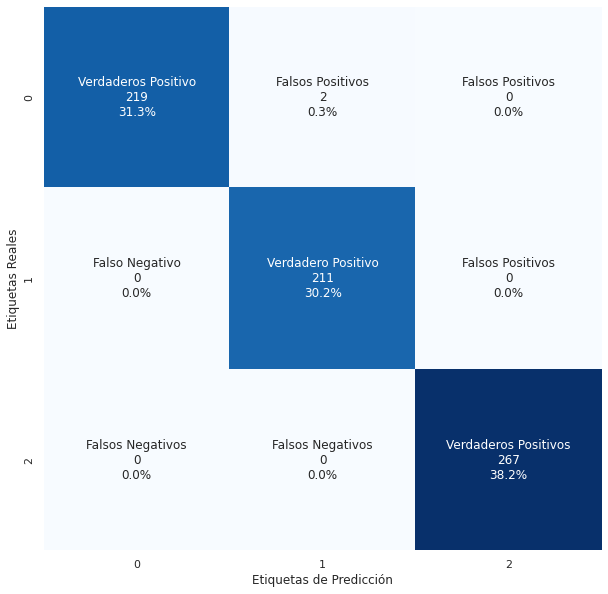

In [137]:
graphConfusionMatirx(cm)